# CMU 95-865 - Unstructured Data Analytics Spring 2022 Quiz 1

**Make sure your Zoom video is on and that you can see/hear the course staff.**

This is an 80 minute exam. We will only grade what is submitted via Canvas.

You must fill in your name and your Andrew ID for this quiz to be graded. Moreover, filling out your name and Andrew ID below will serve as your agreement with us, the course staff, that you did not collaborate with anyone on this exam and that what you submit is truly your own individual work and not that of anyone else. Violations found will result in severe penalties.

Your name: Jingyi Wu

Your Andrew ID: jingyiw2

**Warning: If you leave the above blank, your quiz will not be graded.**

**Important:** There are 2 problems that can be done in either order. The first problem has no coding. The second problem is mostly on coding with a few non-coding interpretation parts. The second problem has 3 parts (a), (b), and (c) that can be done in any order.

**Throughout the coding problem, do not import any additional packages.**

## Problem 1: Co-occurrence analysis (no coding)

*Please do not answer any parts of this problem with code.*

Suppose that we have a collection of text documents, and that someone has already run named entity recognition on each of the documents and found the following named enties (per document, we list the named entities found as a length-2 tuple of the format "(named entity, named entity label)"):

- Document 1: (Alejandro Giammattei, PERSON)
- Document 2: (Pope Francis, PERSON)
- Document 3: (Boris Johnson, PERSON)
- Document 4: (Volodymyr Zelensky, PERSON), (Ukraine, GPE)
- Document 5: (Fumio Kishida, PERSON), (Japan, GPE), (Yoshihide Suga, PERSON)

Each time a named entity appeared in a document, the named entity appeared exactly once.

**(a)** As we discussed in lecture, there are different ways that one can construct a co-occurrence table.

**Subpart i.** Let's first compute a co-occurrence table as follows: count the number of documents that mention both a specific PERSON and a specific GPE.

**Your answer here (fill out the table below; note that rows index people and columns index geopolitical entities)**:

| <i></i>              | Ukraine | Japan |
| -------------------- |:-------:|:-----:|
| Alejandro Giammattei | 0       | 0     |
| Pope Francis         | 0       | 0     |
| Boris Johnson        | 0       | 0     |
| Volodymyr Zelensky   | 1       | 0     |
| Fumio Kishida        | 0       | 1     |
| Yoshihide Suga       | 0       | 1     |

**Subpart ii.** For each of the nonzero counts in your co-occurrence table that you computed in **subpart i**, suppose that we create flashcards (1 per co-occurrence that you counted). For instance, if Pope Francis and Ukraine co-occurred 3 times, then we would create 3 flashcards that say "Pope Francis, Ukraine". We put these flashcards into a bag. What is the probability of drawing a flashcard that says "Yoshihide Suga, Japan"?

**Your answer here:** 1/3

**(b)** (This part does **not** depend on part **(a)**.) Let's consider a different setup from part **(a)**. Suppose that we put documents 1, 2, 3, 4, and 5 into a bag, where drawing any document out of the bag has equal probability (i.e., drawing each document has probability 1/5).

**Subpart i.**  What is the probability that you draw a document in which Yoshihide Suga and Japan co-occur?

**Your answer here:** 1/5, this equals to the probability of drawing out document5, since it is the only one with these two entity co-occuring.

**Subpart ii.** Suppose that we compute PMI as follows:

- Let x = probability of drawing a document from the bag in which named entities A and B both occur.
- Let y = probability of drawing a document from the bag in which named entity A occurs.
- Let z = probability of drawing a document from the bag in which named entity B occurs.
- Let the PMI be given by log(x / (y * z)).

Using the above steps, what is the PMI of Yoshihide Suga and Japan? (Note: leave the base of the log unspecified, i.e., if you think x = 1, y = 1, and z = 1/10, then leave your answer in the form "log(10)".)

**Your answer here:** x=1/5, y("suga")=1/5, z("Japan")=1/5; PMI = log(5)

**Subpart iii.** Using the same way to calculate PMI as stated in **subpart ii**, what is the PMI of Boris Johnson and Ukraine?

**Your answer here:** x = 0, y = 1/5, z = 1/5, PMI = log(0) = negative infinity

**(c)** (This part depends on parts **(a)** (both subparts) and **(b)-subpart i**.) In problem **(a)-subpart ii**, we saw one way to compute the probability in which Yoshihide Suga and Japan co-occur. In problem **(b)-subpart i**, we saw another way to compute the probability in which Yoshihide Suga and Japan co-occur. Briefly explain why the answers that we get are different.

**Your answer here:** In the first way, all we have in the flashcard bag are entity pairs with non-zero co-occurence counts. The cards with only one entity are not considered. But in the second way, what we have in the bag are not only one entity(like only Pope, or only Boris), but also we consider two entity pairs in document5 (Fumio&Japan, Suga&Japan) as only one flashcard. Basically, the denominator of probability is different.

## Problem 2: What quiz questions are in Jeopardy? (coding, with a very brief non-coding component at the very end)

**Warning:** Throughout this problem, we import packages for you. Do **not** import any additional packages.

**Jeopardy!** is an American television game show created by Merv Griffin. The show features a quiz competition in which contestants are presented with general knowledge clues in the form of answers, and must phrase their responses in the form of questions.

In this problem, we analyze a curated set of questions from Jeopardy. We begin by loading in the data.

In [1]:
# DO NOT MODIFY THIS CELL
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.decomposition import PCA

plt.style.use('seaborn')

def read_text_file(filename):
    with open(filename, 'r', encoding='utf8') as f:
        return [line.strip() for line in f.readlines()]

questions = read_text_file('mystery_corn_flakes.txt')
categories = read_text_file('mystery_blackjack.txt')
answers = read_text_file('mystery_justice.txt')
print('Number of questions:', len(questions))

Number of questions: 2588


In [2]:
print(len(questions),len(categories),len(answers))

2588 2588 2588


Note that the i-th question corresponds to the i-th category and to the i-th answer. For instance, `questions[0]` is about the category `categories[0]` and has an answer given by `answers[0]`:

In [3]:
# DO NOT MODIFY THIS CELL
print('Question:', questions[0])
print('Category:', categories[0])
print('Answer:', answers[0])

Question: For the last 8 years of his life, Galileo was under house arrest for espousing this man's theory
Category: HISTORY
Answer: Copernicus


**Please run the cell below before doing anything else for this problem since it can take a little bit of time to run (for us it takes around 1-2 minutes but possibly it can take a bit longer on your machine).** This cell creates a variable `parsed_questions`, which contains spacy Doc objects, one per question in `questions`. In particular, the spacy Doc corresponding to `questions[i]` is `parsed_questions[i]`.

In [4]:
# DO NOT MODIFY THIS CELL
import spacy
nlp = spacy.load('en_core_web_sm', disable=['parser'])
parsed_questions = [nlp(q) for q in questions]

C:\Users\Think\anaconda3\lib\site-packages\spacy\util.py:275: UserWarning: [W031] Model 'en_core_web_sm' (2.2.0) requires spaCy v2.2 and is incompatible with the current spaCy version (2.3.5). This may lead to unexpected results or runtime errors. To resolve this, download a newer compatible model or retrain your custom model with the current spaCy version. For more details and available updates, run: python -m spacy validate
  warnings.warn(warn_msg)


In [5]:
print(len(parsed_questions))

2588


**Warning:** Do **not** modify the variable `parsed_questions`. It is used in different parts of the problem and if you accidentally modify it, you would have to re-run the above cell.

**This problem has been written so that parts (a), (b), and (c) can be done in any order.** For example, if you get stuck on part (b), you can skip over to doing part (c). However, within each of these three parts, the subparts can depend on each other. The first part (a) has no subparts and is intentionally shorter.

**(a)** From one of the code cells we provided above, you should've seen that Copernicus is the answer to the 0-th question "For the last 8 years of his life, Galileo was under house arrest for espousing this man's theory". One can check that the string `"Copernicus"` does *not* actually appear anywhere in the questions in the dataset that we loaded in (in other words, no string in the list `questions` contains the substring `"Copernicus"`).

Write code that determines what fraction of the strings stored in `answers` can be found anywhere in the strings of `questions`.

Write code to determine the fraction of the strings in `answers` that can be found in **any strings** of questions. **Each element in the answers list is considered as one string. Your code should not split any strings by spaces.** For instance, suppose that `answers` consisted of three strings `"Marie Curie"`, `"Nikola Tesla"`, and `"Sandro Botticelli"`. If `"Marie Curie"` is contained in at least one of the strings in `questions`, but `"Nikola Tesla"` and `"Sandro Botticelli"` are *not* contained in any of the strings in `questions`, then the answer to this question would be 1/3. **For simplicity, do not convert any of the text to lowercase or uppercase--leave the casing the same and check for matches in a case-sensitive manner.**

Hint: To see if the string `x` is in another string `y`, you can use the boolean expression `x in y`. For instance, `'Galileo' in questions[0]` returns `True` (indeed, `'Galileo'` is a substring contained in `questions[0]`).

In [6]:
# <------------------- YOUR CODE HERE ----------------------------->
found_matches = 0

parsed_questions_flatten = [token.orth_ for question in parsed_questions for token in question]
for answer in answers:
    if answer in parsed_questions_flatten:
        found_matches+=1
# <------------------- END OF YOUR CODE --------------------------->

# DO NOT MODIFY THE LINE BELOW
print('Fraction of answers that are contained in questions:', found_matches / len(answers))

Fraction of answers that are contained in questions: 0.160741885625966


*It turns out that most answers cannot be found in the questions, meaning that with only access to the questions (and not the answers) and no other datasets, we really can't hope to answer most of the questions!*

**(b)** Many questions in the dataset involve dates. Does Jeopardy tend to favor particular dates in terms of the questions asked? To answer this, we focus just on *years* rather than specific dates that include months or days.

**Subpart i.** For each question in the dataset, look for named entities with the label `'DATE'` and that have string representations that are each exactly 4 characters long and consist only of digits---we shall assume that named entities satisfying these conditions correspond to years. Create a histogram `year_counter` (that is a `Counter` instance) that counts how often each year appears. **Important**: Your `year_counter` should have each key/value pair correspond to a year (integer)/raw count frequency (integer) pair.

Note: in writing your code, please make use of the `parsed_questions` variable that we defined at the start of Problem 2 (that involves spaCy doing the parsing of the different questions). You should *not* have to re-run spaCy parsing!

Hint: if the variable `x` is a string, then `x.isdigit()` checks whether `x` consists of digits.

In [7]:
for entity in parsed_questions[0].ents:
    print(entity.label_.isdigit())

False
False


In [8]:
year_counter = Counter()  # do not change this line; your code below should populate `year_counter`

# <------------------- YOUR CODE HERE ----------------------------->
for question in parsed_questions:
    for entity in question.ents:
        if entity.label_ =='DATE' and len(str(entity))==4 and str(entity).isdigit():
            year = int(str(entity))
            year_counter[year] +=1

for year, value in year_counter.items():
    print(year,": ", value)
# <------------------- END OF YOUR CODE --------------------------->

1889 :  3
1885 :  5
1900 :  6
1872 :  3
1949 :  3
1951 :  4
1789 :  3
1877 :  2
1917 :  6
1791 :  2
1863 :  6
1698 :  1
1856 :  6
1798 :  3
1980 :  4
1621 :  2
1784 :  1
1991 :  6
1969 :  7
1919 :  3
1934 :  6
1823 :  3
1935 :  4
2001 :  6
2003 :  4
1763 :  1
1864 :  2
1832 :  3
1429 :  2
1778 :  3
1835 :  7
1909 :  2
1938 :  7
1962 :  4
1787 :  2
1975 :  11
1968 :  4
1999 :  5
1855 :  2
1862 :  2
1965 :  4
1967 :  5
1898 :  4
1273 :  1
1972 :  4
1989 :  6
1883 :  1
1986 :  4
1803 :  6
1896 :  2
1943 :  5
1961 :  6
1530 :  1
1645 :  1
1650 :  2
1794 :  2
1605 :  2
1933 :  3
1904 :  3
2000 :  2
1899 :  5
1819 :  3
1871 :  4
2011 :  1
1297 :  1
1944 :  2
1199 :  2
1818 :  2
1960 :  7
1950 :  5
1971 :  5
1910 :  8
1849 :  4
1861 :  5
1806 :  2
1977 :  5
1996 :  5
1981 :  3
1918 :  4
1920 :  7
1854 :  3
1820 :  3
1922 :  8
1888 :  5
1936 :  2
1415 :  1
1963 :  3
1945 :  3
1756 :  1
1066 :  2
1952 :  9
1847 :  3
1642 :  1
1958 :  4
1358 :  1
1392 :  1
1648 :  1
1988 :  5
1492 :  3
1455 :  1

**Subpart ii.** spaCy's named entity recognition isn't always accurate. Let's do a quick sanity check. What are the minimum and maximum years that you found (stored in `year_counter`)? To answer this question, write code that prints out the minimum and maximum years found. Note that we are asking about minimum as in earliest in time, and maximum as it latest in time----we are **not** asking about minimum as in least frequent and maximum as in most frequent.

In [9]:
# <------------------- YOUR CODE HERE ----------------------------->
min_year_found = min(list(year_counter.elements()))
max_year_found = max(list(year_counter.elements()))

# <------------------- END OF YOUR CODE --------------------------->

# DO NOT MODIFY THE CODE BELOW
print('Min year found:', min_year_found)
print('Max year found:', max_year_found)

Min year found: 1025
Max year found: 2500


**Subpart iii.** Write code that finds and prints out all questions that contain a named entity corresponding to the minimum year found, and separately all questions that contain a named entity corresponding to the maximum year found. (These named entities should use the same filters as in **subpart i** to determine whether they are considered a year or not.)

In [10]:
print('[Question(s) containing the minimum year found]')  # DO NOT MODIFY THIS LINE

# <------ YOUR CODE HERE FOR PRINTING OUT QUESTION(S) CONTAINING THE MINIMUM YEAR FOUND ------>
for question in parsed_questions:
    entity_list = [str(entity) for entity in question.ents]
    if str(min_year_found) in entity_list:
        print(question)
# <------ END OF YOUR CODE FOR PRINTING OUT QUESTION(S) CONTAINING THE MINIMUM YEAR FOUND ---->


print("\n[Question(s) containing the maximum year found]")  # DO NOT MODIFY THIS LINE

# <------ YOUR CODE HERE FOR PRINTING OUT QUESTION(S) CONTAINING THE MAXIMUM YEAR FOUND ------>
for question in parsed_questions:
    entity_list = [str(entity) for entity in question.ents]
    if str(max_year_found) in entity_list:
        print(question)
# <------ END OF YOUR CODE FOR PRINTING OUT QUESTION(S) CONTAINING THE MAXIMUM YEAR FOUND ---->

[Question(s) containing the minimum year found]
In 1025 Boleslaw I became this country's first king but died within the year

[Question(s) containing the maximum year found]
Around 2500 B.C. the Harappan Civilization sprung up around this river in Pakistan & nothwestern India


*Different versions of spaCy can detect different named entities a bit differently. We'll just say that when we run this, the minimum and maximum years actually do correspond to years and aren't errors in named entity recognition (although perhaps you get a different result).*

**Subpart iv.** Plot a histogram showing years 1900 to 2000 (including both 1900 and 2000) of the year counter. The x axis (corresponding to years) should be in chronological order. Be sure to label your x-axis and y-axis.

[(1975, 11), (1952, 9), (1910, 8), (1922, 8), (1912, 8), (1969, 7), (1835, 7), (1938, 7), (1960, 7), (1920, 7)]


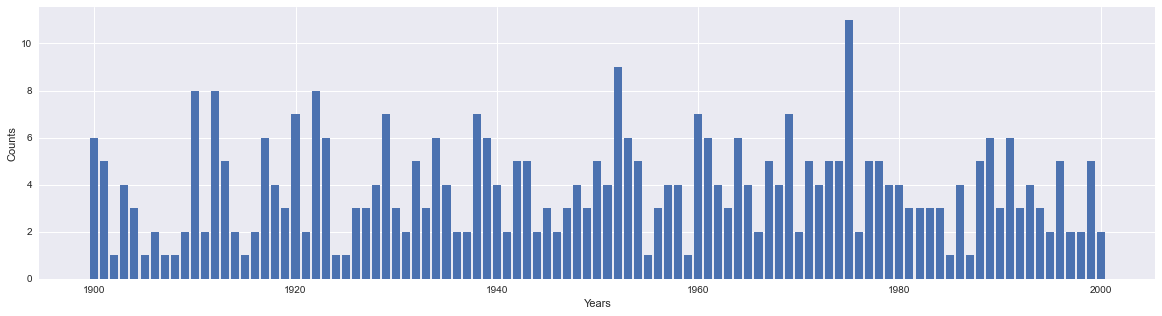

In [11]:
plt.figure(figsize=(20, 5))

# <------------------- YOUR CODE HERE ----------------------------->
x = list(year_counter.elements())
x = [i for i in x if i>=1900 and i<=2000]
x = np.sort(np.array(x))

y = [year_counter[i] for i in x]
y = np.array(y)
print(year_counter.most_common(10))

plt.bar(x,y)
plt.xlabel("Years")
plt.ylabel("Counts")
plt.show()
# <------------------- END OF YOUR CODE --------------------------->

What do you observe? Are there any specific years which are immensely popular or is the distribution well spread out?

**Your answer here**: Year 1975, 1952, 1910, 1922 are immensely popular. The distribution appears some cycle pattern.

**(c)** In this part, we try to understand how questions in the category `"WORLD HISTORY"` differ from the ones in the category `"LITERATURE"`. We shall do this using both frequency analysis and dimensionality reduction.

**Subpart i.** Write code that obtains the subset of `questions`, `parsed_questions`, and `categories` for which `categories` is either `"WORLD HISTORY"` or `"LITERATURE"`. Store the resulting subsets in the variables `subset_questions`, `subset_parsed_questions`, and `subset_categories` respectively (so that `subset_questions[i]` has category given by `subset_categories[i]`, which should always be either `"WORLD HISTORY"` or `"LITERATURE"`, and the spaCy-parsed version of `subset_questions[i]` is in `subset_parsed_questions[i]`). You should *not* have to re-run spaCy parsing!

Note that for this part, we will not use the `answers` variable.

If your code works correctly, then `len(subset_questions)` should equal 873.

In [12]:
# <------------------- YOUR CODE HERE ----------------------------->
subset_questions = None
subset_categories = None
subset_parsed_questions = None

index = [(cate=='WORLD HISTORY' or cate=='LITERATURE') for cate in categories ]

subset_questions = np.array(questions)[index]
subset_categories = np.array(categories)[index]
subset_parsed_questions = np.array(parsed_questions)[index]

# <------------------- END OF YOUR CODE --------------------------->

<ipython-input-12-bf7baf5cbfb3>:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  subset_parsed_questions = np.array(parsed_questions)[index]


**Subpart ii.** Let's now represent the questions as feature vectors. We first load in the vocabulary words that we will keep track of:

In [13]:
# DO NOT MODIFY THIS CELL
vocab = read_text_file('mystery_feather.txt')
print(len(vocab))

1130


We will only be keeping track of how often the words in `vocab` appear. In the code cell below, please write code that fills in the variable `term_frequency_table` (a 2D numpy array, where rows correspond to questions in the same order as they appear in `subset_questions` that you computed in **subpart i**, and columns correspond to the different vocabulary words in the same order as they appear in `vocab`).

To fill in `term_frequency_table`, remember that the i-th row corresponds to a Jeopardy question `subset_questions[i]`, for which you already have the parsed version (a spacy Doc given by `subset_parsed_questions[i]`). Iterate through the tokens of this parsed spacy Doc, convert each token to lowercase (do not lemmatize) and if the lowercase token appears in `vocab`, then you increment the count for the lowercase token by 1 in the i-th row of `term_frequency_table` (you have to figure out what column index the token corresponds to).

For example, `vocab[200]` is the word `"early"`. If `subset_questions[5]` were to correspond to a Jeopardy question for which the word `"early"` shows up 17 times (according to the tokens found by spaCy, converted to lowercase), then `term_frequency_table[5, 200]` would be equal to 17.

In [14]:
for token in subset_parsed_questions[0]:
    print(str(token).lower())

in
chapter
52
of
this
novel
,
a
boisterous
crowd
is
gathering
for
fagin
's
execution


In [15]:
term_frequency_table = np.zeros((len(subset_questions), len(vocab)))

# <------------------- YOUR CODE HERE ----------------------------->
for i in range(len(subset_parsed_questions)):
    question = subset_parsed_questions[i]        
    for token in question:
        for j in range(len(vocab)):
            
            if token.orth_.lower() == vocab[j]:
                print(token.orth_.lower,vocab[j])
                num = term_frequency_table[i][j]+1
                term_frequency_table[i,j]=num
                break

term_frequency_table
# <------------------- END OF YOUR CODE --------------------------->

<built-in method lower of str object at 0x000001ECD4CEA3B0> chapter
<built-in method lower of str object at 0x000001ECD4D0BBF0> 52
<built-in method lower of str object at 0x000001ECD4D0BBF0> novel
<built-in method lower of str object at 0x000001ECD4D0BBF0> 19th
<built-in method lower of str object at 0x000001ECD4D0BBF0> author
<built-in method lower of str object at 0x000001ECD4CE4DB0> known
<built-in method lower of str object at 0x000001ECD4D0BBF0> writing
<built-in method lower of str object at 0x000001ECD4D0BBF0> mansion
<built-in method lower of str object at 0x000001ECD4D0BBF0> seven
<built-in method lower of str object at 0x000001ECD4CE4DB0> people
<built-in method lower of str object at 0x000001ECCD360830> appear
<built-in method lower of str object at 0x000001ECCD360830> brother
<built-in method lower of str object at 0x000001ECD4CE4DB0> sister
<built-in method lower of str object at 0x000001ECD4CE4DB0> author
<built-in method lower of str object at 0x000001ECD4CE4DB0> jungle


array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

**Subpart iii.** Unfortunately, using this term frequency representation, at least one question ends up getting represented as all 0's. Write code that prints out the question(s) that get represented as all 0's (i.e., these questions correspond to rows of `term_frequency_table` that are all 0's). Importantly, we are asking about printing the original question (from `subset_questions`) and *not* the raw counts representation.

In [17]:
term_frequency_table.shape

(873, 1130)

In [24]:
# <------------------- YOUR CODE HERE ----------------------------->
all_zero_questions= subset_questions[term_frequency_table.sum(axis=1)==0]
all_zero_questions[0]
# <------------------- END OF YOUR CODE --------------------------->

"Shaw's scorched saint"

**Subpart iv.** Notice that if we look at only the rows of `term_frequency_table` that correspond to the category `"WORLD HISTORY"`, then if we sum across these rows, we actually get the overall term frequencies for `"WORLD HISTORY"` questions---this could be thought of as collection term frequencies, where the "collection" is the set of `"WORLD HISTORY"` questions. Using this idea, compute the collection term frequencies for `"WORLD HISTORY"` questions, and separately the collection term frequencies for `"LITERATURE"` questions. Then print out the top 10 words for each of these, along with their counts.

In writing your code here, please work off of `term_frequency_table`. No credit will be given if you create a new histogram/`Counter` from scratch. As a reminder, please do not import any additional packages.

In [29]:
len(vocab)

1130

In [33]:
# <------ YOUR CODE HERE TO COMPUTE THE COLLECTION TERM FREQUENCIES ------>
ctf_world_history = term_frequency_table[subset_categories=='WORLD HISTORY'].sum(axis=0)
ctf_literature = term_frequency_table[subset_categories=='LITERATURE'].sum(axis=0)
# <------ END OF YOUR CODE TO COMPUTE THE COLLECTION TERM FREQUENCIES ---->



print("[Top words for world history]") # DO NOT MODIFY THIS LINE

# <------ YOUR CODE HERE TO PRINT OUT THE TOP 10 WORDS ALONG WITH THEIR COUNTS FOR WORLD HISTORY ------------->
ranking1 = np.argsort(-ctf_world_history)
index=1
vocab_ranked = [vocab[index] for index in ranking1]
ctf_world_history_ranked = [ctf_world_history[index] for index in ranking1]
for word,count in zip(vocab_ranked,ctf_world_history_ranked):
    print("Ranking: ", index, " | ",word," | ",count)
    index+=1
    if index==11:
        break


# <------ END OF YOUR CODE HERE TO PRINT OUT THE TOP 10 WORDS ALONG WITH THEIR COUNTS FOR WORLD HISTORY ------>


print("\n[Top words for literature]") # DO NOT MODIFY THIS LINE

# <------ YOUR CODE HERE TO PRINT OUT THE TOP 10 WORDS, ALONG WITH THEIR COUNTS FOR LITERATURE ------------>
ranking2 = np.argsort(-ctf_literature)
index=1
vocab_ranked2 = [vocab[index] for index in ranking2]
ctf_literature_ranked = [ctf_literature[index] for index in ranking2]

for word,count in zip(vocab_ranked2,ctf_literature_ranked):
    print("Ranking: ", index, " | ",word," | ",count)
    index+=1
    if index==11:
        break
# <------ END OF YOUR CODE HERE TO PRINT OUT THE TOP 10 WORDS ALONG WITH THEIR COUNTS FOR LITERATURE ------>

[Top words for world history]
Ranking:  1  |  country  |  75.0
Ranking:  2  |  king  |  37.0
Ranking:  3  |  war  |  30.0
Ranking:  4  |  city  |  26.0
Ranking:  5  |  battle  |  19.0
Ranking:  6  |  great  |  18.0
Ranking:  7  |  years  |  18.0
Ranking:  8  |  england  |  15.0
Ranking:  9  |  island  |  15.0
Ranking:  10  |  century  |  13.0

[Top words for literature]
Ranking:  1  |  novel  |  165.0
Ranking:  2  |  title  |  57.0
Ranking:  3  |  wrote  |  46.0
Ranking:  4  |  author  |  36.0
Ranking:  5  |  published  |  33.0
Ranking:  6  |  book  |  32.0
Ranking:  7  |  work  |  28.0
Ranking:  8  |  story  |  28.0
Ranking:  9  |  character  |  28.0
Ranking:  10  |  tale  |  27.0


**Subpart v.** We now use dimensionality reduction to help visualize the data in 2D.

First, we normalize the data. Specifically, we convert each question's raw count representation into fractional frequencies instead so that every question's feature vector's entries sum to 1 except for question's whose raw counts are all 0's. For just those cases, we leave their representation the same. Write code that computes this normalized representation and stores the resulting table in the variable `term_frequency_table_frac`. In particular, `term_frequency_table_frac` should be a 2D numpy table with the same shape as `term_frequency_table`; the i-th row of `term_frequency_table_frac` should correspond to the same underlying Jeopardy question as `term_frequency_table`.

In [34]:
# <------------------- YOUR CODE HERE ----------------------------->
term_frequency_table_frac = term_frequency_table/term_frequency_table.sum()
# <------------------- END OF YOUR CODE --------------------------->

Next, write code that creates a 1D numpy array called `world_history_mask`, where the number of entries is given by `len(subset_categories)`, and the i-th entry is 1 if `subset_categories[i]` is equal to `"WORLD HISTORY"`, and the i-th entry is 0 otherwise.

In [39]:
# <------------------- YOUR CODE HERE ----------------------------->
world_history_mask = np.asarray([1 if cate=="WORLD HISTORY" else 0 for cate in subset_categories ])
world_history_mask.shape
# <------------------- END OF YOUR CODE --------------------------->

(873,)

If your code is correct, then the code cell below should plot the 2D PCA representation for you and also print out the explained variance ratios.

Explained variance ratios: [0.03100627 0.01822993]


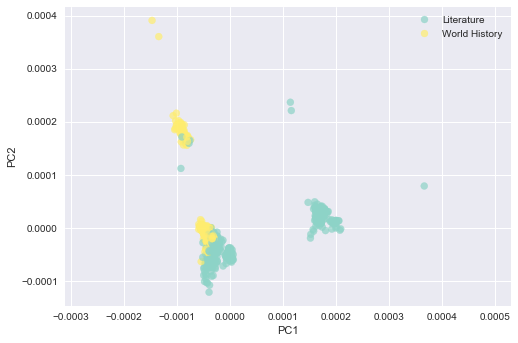

In [40]:
# DO NOT MODIFY
pca = PCA(n_components=2)
feature_vectors_pca2d = pca.fit_transform(term_frequency_table_frac)
scatter = plt.scatter(feature_vectors_pca2d[:, 0], feature_vectors_pca2d[:, 1],
                      c=world_history_mask,
                      cmap='Set3', alpha=0.7)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.legend(handles=scatter.legend_elements()[0], labels=['Literature', 'World History'])
plt.axis('equal')

print('Explained variance ratios:', pca.explained_variance_ratio_)

Even though the explained variance is low, it should be clear from the plot that questions from the two categories can actually often be distinguished from each other based on this 2D PCA representation!

Which of the two principal components would you focus on to try to identify words most related to `"WORLD HISTORY"`? Would these words have the most negative or the most positive weights for this particular principal component?

In [47]:
(pca.components_[0]<0).sum()/pca.components_[0].shape[0]

0.6380530973451327

**Your answer here (do not write code for this problem; please answer this as a non-coding question):** 
the first component always gives the most expained variance of data, so the first one. These words have the most negative weights for the first component, taking up 63.8%.